原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Classifying newswires: a multi-class classification example
# 新闻分类：多分类问题

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.


上一节中，我们介绍了如何用密集连接的神经网络将向量输入划分为两个互斥的类别。但如果类别不止两个，要怎么做？

本节你会构建一个网络，将路透社新闻划分为 46 个互斥的主题。因为有多个类别，所以这是多分类（multiclass classification）问题的一个例子。因为每个数据点只能划分到一个类别，所以更具体地说，这是单标签、多分类（single-label, multiclass classification）问题的一个例子。如果每个数据点可以划分到多个类别（主题），那它就是一个多标签、多分类（multilabel, multiclass classification）问题。


## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

## 路透社数据集

本节使用路透社数据集，它包含许多短新闻及其对应的主题，由路透社在 1986 年发布。它是一个简单的、广泛使用的文本分类数据集。它包括 46 个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少 10 个样本。

与 IMDB 和 MNIST 类似，路透社数据集也内置为 Keras 的一部分。我们来看一下。


In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

与 IMDB 数据集一样，参数 num_words=10000 将数据限定为前 10 000 个最常出现的单词。 我们有 8982 个训练样本和 2246 个测试样本。（这里下载可能会失败几次，不翻墙可以下的）

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

与 IMDB 评论一样，每个样本都是一个整数列表（表示单词索引）。

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

如果好奇的话，你可以用下列代码将索引解码为单词。

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3（注 意，索引减去了 3）
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
#（因为 0、1、2 是 为“padding”（ 填 充 ）、“start of sequence”（序列开始）、“unknown”（未知词）分别保留的索引）
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

样本对应的标签是一个 0~45 范围内的整数，即话题索引编号。

In [8]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:
## 准备数据
你可以使用与上一个例子相同的代码将数据向量化。


In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data（将训练数据向量化）
x_train = vectorize_sequences(train_data)
# Our vectorized test data（将测试数据向量化）
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

将标签向量化有两种方法：你可以将标签列表转换为整数张量，或者使用 one-hot 编码。

one-hot 编码是分类数据广泛使用的一种格式，也叫分类编码（categorical encoding）。6.1 节给出了 one-hot 编码的详细解释。在这个例子中，标签的 one-hot 编码就是将每个标签表示为全零向量，只有标签索引对应的元素为 1。其代码实现如下。


In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels（将训练标签向量化）
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels（将测试标签向量化）
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

注意，Keras 内置方法可以实现这个操作，你在 MNIST 例子中已经见过这种方法。

In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:
## 构建网络

这个主题分类问题与前面的电影评论分类问题类似，两个例子都是试图对简短的文本片段进行分类。但这个问题有一个新的约束条件：输出类别的数量从 2 个变为 46 个。输出空间的维度要大得多。

对于前面用过的 Dense 层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。上一个例子使用了 16 维的中间层，但对这个例子来说 16 维空间可能太小了，无法学会区分 46 个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。

出于这个原因，下面将使用维度更大的层，包含 64 个单元。


In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

关于这个架构还应该注意另外两点。

* 网络的最后一层是大小为 46 的 Dense 层。这意味着，对于每个输入样本，网络都会输出一个 46 维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。

* 最后一层使用了 softmax 激活。你在 MNIST 例子中见过这种用法。网络将输出在 46 个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个 46 维向量，其中 output[i] 是样本属于第 i 个类别的概率。46 个概率的总和为 1。

对于这个例子，最好的损失函数是 `categorical_crossentropy`（分类交叉熵）。它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。


In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

## 验证你的方法
我们在训练数据中留出 1000 个样本作为验证集。


In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

现在开始训练网络，共 20 个轮次。

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 157us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 120us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 122us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 121us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 121us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 122us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 121us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


Let's display its loss and accuracy curves:

我们来绘制损失曲线和精度曲线：

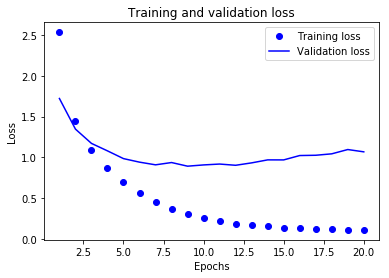

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

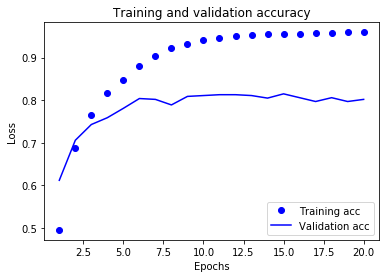

In [18]:
plt.clf()   # clear figure(清空图像)

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

网络在训练8 轮后开始过拟合。我们从头开始训练一个新网络，共8个轮次，然后在测试集上评估模型。

In [19]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 152us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/8
7982/7982 [==============================] - 1s 129us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/8
7982/7982 [==============================] - 1s 126us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/8
7982/7982 [==============================] - 1s 129us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/8
7982/7982 [==============================] - 1s 121us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/8
7982/7982 [==============================] - 1s 121us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/8
7982/7982 [==============================] - 1s 123us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [20]:
results

[0.9847470230007427, 0.7845057880676759]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

这种方法可以得到约 78% 的精度。对于平衡的二分类问题，完全随机的分类器能够得到50%的精度。但在这个例子中，完全随机的精度约为19%，所以上述结果相当不错，至少和随机的基准比起来还不错。


In [21]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19679430097951914

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:
## 在新数据上生成预测结果

你可以验证，模型实例的 predict 方法返回了在 46 个主题上的概率分布。我们对所有测试数据生成主题预测。


In [22]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

predictions 中的每个元素都是长度为 46 的向量。

In [23]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

这个向量的所有元素总和为 1。

In [24]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

最大的元素就是预测类别，即概率最大的类别。

In [25]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:
## 处理标签和损失的另一种方法
前面提到了另一种编码标签的方法，就是将其转换为整数张量，如下所示。


In [26]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

对于这种编码方法，唯一需要改变的是损失函数的选择。对于代码清单 3-21 使用的损失 函数 categorical_crossentropy，标签应该遵循分类编码。对于整数标签，你应该使用 sparse_categorical_crossentropy。

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

这个新的损失函数在数学上与 categorical_crossentropy 完全相同，二者只是接口不同。

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.
## 中间层维度足够大的重要性

前面提到，最终输出是 46 维的，因此中间层的隐藏单元个数不应该比 46 小太多。现在来 看一下，如果中间层的维度远远小于 46（比如 4 维），造成了信息瓶颈，那么会发生什么？


In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 190us/step - loss: 2.7073 - acc: 0.4411 - val_loss: 2.0155 - val_acc: 0.5930
Epoch 2/20
7982/7982 [==============================] - 1s 169us/step - loss: 1.7341 - acc: 0.6183 - val_loss: 1.6573 - val_acc: 0.6100
Epoch 3/20
7982/7982 [==============================] - 1s 170us/step - loss: 1.4678 - acc: 0.6359 - val_loss: 1.5688 - val_acc: 0.6080
Epoch 4/20
7982/7982 [==============================] - 1s 176us/step - loss: 1.3273 - acc: 0.6446 - val_loss: 1.4833 - val_acc: 0.6170
Epoch 5/20
7982/7982 [==============================] - 1s 173us/step - loss: 1.2168 - acc: 0.6498 - val_loss: 1.4540 - val_acc: 0.6250
Epoch 6/20
7982/7982 [==============================] - 1s 168us/step - loss: 1.1265 - acc: 0.6753 - val_loss: 1.4326 - val_acc: 0.6350
Epoch 7/20
7982/7982 [==============================] - 1s 174us/step - loss: 1.0522 - acc: 0.6944 - val_loss: 1.4520 - val_acc: 0.6420



Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

现在网络的验证精度最大约为 71%，比前面下降了 8%。导致这一下降的主要原因在于，你试图将大量信息（这些信息足够恢复 46 个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。



## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## 进一步的实验
* 尝试使用更多或更少的隐藏单元，比如 32 个、128 个等。

* 前面使用了两个隐藏层，现在尝试使用一个或三个隐藏层。


## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.

## 小结
下面是你应该从这个例子中学到的要点。

* 如果要对 N 个类别的数据点进行分类，网络的最后一层应该是大小为 N 的 Dense 层。
* 对于单标签、多分类问题，网络的最后一层应该使用 softmax 激活，这样可以输出在 N个输出类别上的概率分布。
* 这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的 真实分布之间的距离最小化。
* 处理多分类问题的标签有两种方法。
* 通过分类编 码（也叫 one-hot 编码）对标签进行编码，然后使用 categorical_crossentropy 作为损失函数。
*  将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数。
* 如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈。
